# SemEval 2026 Task 4 - Siamese Network for Text Similarity

This notebook implements a Siamese Network to classify whether `text_a` is closer to `anchor_text` than `text_b`.
We evaluate two models:
1. BERT (`bert-base-uncased`)
2. RoBERTa (`roberta-base`)

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm

# Set device
if torch.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## 1. Data Loading and Preprocessing

In [110]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = text.replace("\u200b", "")  # zero-width spaces
    return text

def load_and_clean_data():
    # Load datasets
    try:
        df_dev = pd.read_json('data/SemEval2026-Task_4-dev-v1/dev_track_a.jsonl', lines=True)
        df_syn = pd.read_json('data/SemEval2026-Task_4-dev-v1/synthetic_data_for_classification.jsonl', lines=True)
    except ValueError as e:
        print(f"Error loading data: {e}")
        return None

    # Select relevant columns
    cols = ['anchor_text', 'text_a', 'text_b', 'text_a_is_closer']
    df_dev = df_dev[cols].copy()
    
    if 'model_name' in df_syn.columns:
        df_syn.drop('model_name', axis=1, inplace=True)
    df_syn = df_syn[cols].copy()

    # Concatenate
    df = pd.concat([df_dev, df_syn], ignore_index=True)
    
    # Remove nulls
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Preprocess text columns
    for col in ['anchor_text', 'text_a', 'text_b']:
        df[col] = df[col].apply(preprocess_text)
        
    # Convert boolean label to int (True -> 1, False -> 0)
    df['label'] = df['text_a_is_closer'].astype(int)
    
    return df

df = load_and_clean_data()
print(f"Total samples: {len(df)}")
df.head()

Total samples: 2097


,anchor_text,text_a,text_b,text_a_is_closer,label
0,The book follows an international organization...,The old grandmother Tina arrives in town to at...,The nano-plague that poisoned Earth's water su...,False,0
1,"Glenn Tyler (Elvis Presley), a childish 25-yea...","Bill Babbitt supported the death penalty, unti...",A white-collar suburban father Kyle (Fran Kran...,True,1
2,Signaller Charles Plumpick (Bates) is a kilt-w...,"Sid, Russ and Jerry are three wannabe criminal...",Brendan Byers III is a rich playboy who enlist...,False,0
3,Barbara is married to the distinguished profes...,Eddie Quinn's unruly wife Maureen drinks and s...,Jerome Littlefield is an orderly at a hospital...,False,0
4,A wealthy widower locks up his two grown-up ch...,Barbara is married to the distinguished profes...,Stefano (Lino Capolicchio) arrives in a villag...,False,0


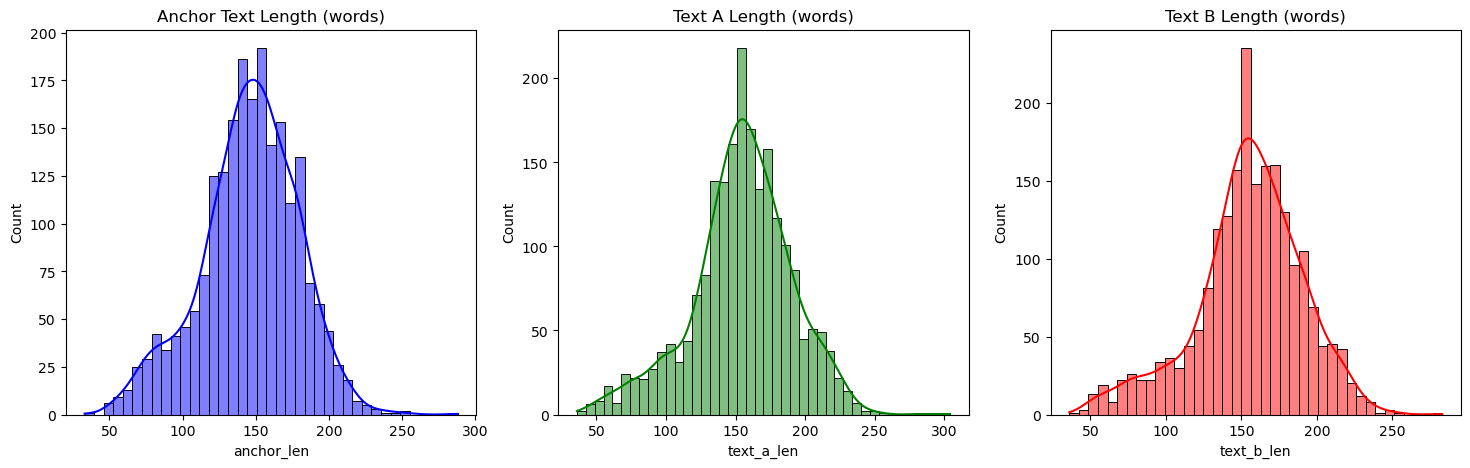

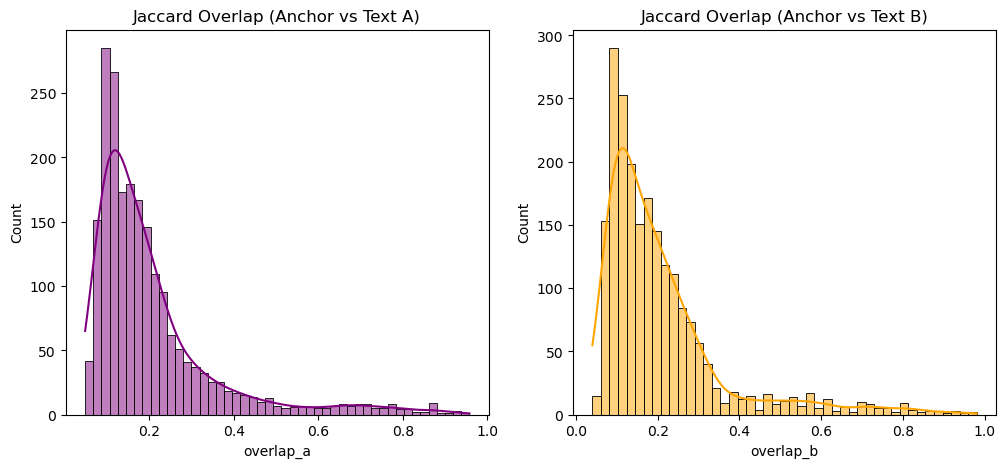

Heuristic Accuracy (Higher Overlap = Closer): 92.37%


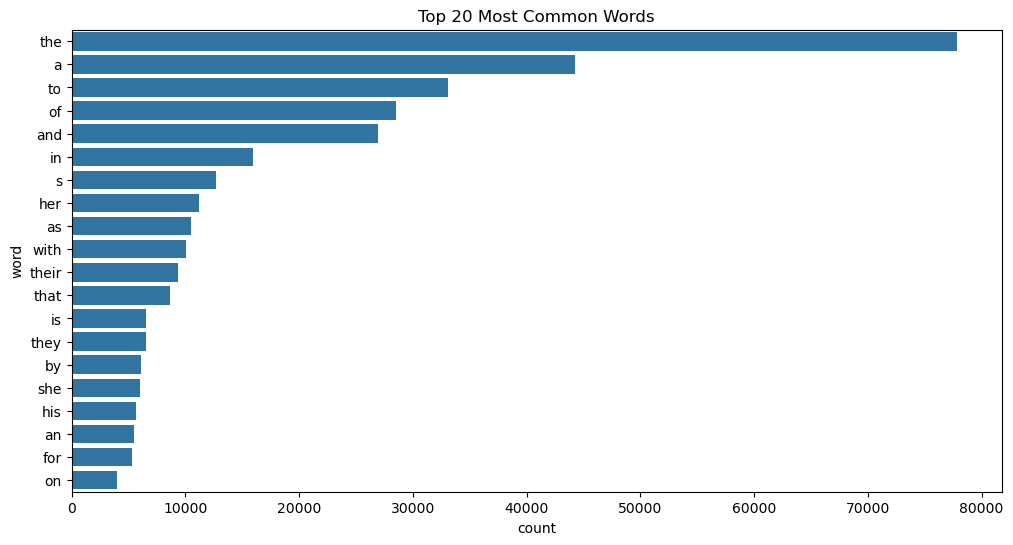

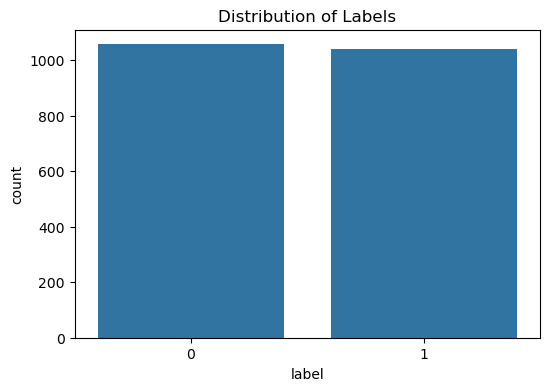

In [111]:
# Enhanced EDA

# 1. Text Length Analysis
df['anchor_len'] = df['anchor_text'].apply(lambda x: len(str(x).split()))
df['text_a_len'] = df['text_a'].apply(lambda x: len(str(x).split()))
df['text_b_len'] = df['text_b'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['anchor_len'], ax=axes[0], kde=True, color='blue').set_title('Anchor Text Length (words)')
sns.histplot(df['text_a_len'], ax=axes[1], kde=True, color='green').set_title('Text A Length (words)')
sns.histplot(df['text_b_len'], ax=axes[2], kde=True, color='red').set_title('Text B Length (words)')
plt.show()

# 2. Lexical Overlap (Jaccard Similarity)
def jaccard_similarity(str1, str2):
    a = set(str(str1).lower().split())
    b = set(str(str2).lower().split())
    c = a.intersection(b)
    if len(a) + len(b) - len(c) == 0:
        return 0
    return float(len(c)) / (len(a) + len(b) - len(c))

df['overlap_a'] = df.apply(lambda x: jaccard_similarity(x['anchor_text'], x['text_a']), axis=1)
df['overlap_b'] = df.apply(lambda x: jaccard_similarity(x['anchor_text'], x['text_b']), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['overlap_a'], ax=axes[0], kde=True, color='purple').set_title('Jaccard Overlap (Anchor vs Text A)')
sns.histplot(df['overlap_b'], ax=axes[1], kde=True, color='orange').set_title('Jaccard Overlap (Anchor vs Text B)')
plt.show()

# Correlation with Label
df['heuristic_pred'] = (df['overlap_a'] > df['overlap_b']).astype(int)
heuristic_acc = (df['heuristic_pred'] == df['label']).mean()
print(f"Heuristic Accuracy (Higher Overlap = Closer): {heuristic_acc:.2%}")

# 3. Top Words
from collections import Counter
all_text = " ".join(df['anchor_text'].tolist() + df['text_a'].tolist() + df['text_b'].tolist())
words = re.findall(r'\w+', all_text.lower()) # Better tokenization
word_counts = Counter(words)
common_words = word_counts.most_common(20)

words_df = pd.DataFrame(common_words, columns=['word', 'count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=words_df)
plt.title('Top 20 Most Common Words')
plt.show()

# Label Distribution (Original)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.show()

## 2. Dataset and DataLoader

In [112]:
class SiameseDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        anchor = row['anchor_text']
        text_a = row['text_a']
        text_b = row['text_b']
        label = row['label']

        encoding_anc = self.tokenizer(
            anchor,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        # Tokenize (Anchor, Text A)
        encoding_a = self.tokenizer(
            text_a,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        # Tokenize (Anchor, Text B)
        encoding_b = self.tokenizer(
            text_b,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids_anc': encoding_anc['input_ids'].flatten(),
            'attention_mask_anc': encoding_anc['attention_mask'].flatten(),
            'input_ids_a': encoding_a['input_ids'].flatten(),
            'attention_mask_a': encoding_a['attention_mask'].flatten(),
            'input_ids_b': encoding_b['input_ids'].flatten(),
            'attention_mask_b': encoding_b['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

## Task B data set and EDA

In [113]:
df_task_b = pd.read_json("data/SemEval2026-Task_4-dev-v1/dev_track_b.jsonl", lines=True)
df_task_b.head()

,text
0,The old grandmother Tina arrives in town to at...
1,The nano-plague that poisoned Earth's water su...
2,The book follows an international organization...
3,"Bill Babbitt supported the death penalty, unti..."
4,A white-collar suburban father Kyle (Fran Kran...


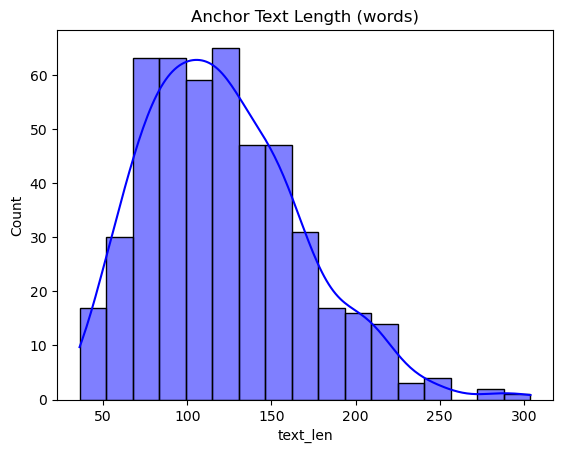

In [114]:
df_task_b['text_len'] = df_task_b['text'].apply(lambda x: len(str(x).split()))

sns.histplot(df_task_b['text_len'], kde=True, color='blue').set_title('Anchor Text Length (words)')
plt.show()

## Data loader for task B

In [115]:
class TaskBDataLoader(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        text = item['text']
        
        # Check if it's the custom SimpleTokenizer (duck typing)
        if hasattr(self.tokenizer, 'word2idx'):
            ids = self.tokenizer.encode(text, self.max_len)
            mask = [1 if i != 0 else 0 for i in ids]
            return {
                'input_ids': torch.tensor(ids, dtype=torch.long),
                'attention_mask': torch.tensor(mask, dtype=torch.long)
            }
        else:
            # Hugging Face Tokenizer
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten()
            }


## 3. Generic Model Definition

In [116]:
class SiameseModel(nn.Module):
    def __init__(self, model_name):
        super(SiameseModel, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.backbone = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        
        # Determine hidden size from config
        hidden_size = self.config.hidden_size
        
        # Classifier head: (u, v, |u-v|) -> 3 * hidden_size
        self.fc = nn.Linear(hidden_size * 5, 2) 
        
    def embeddings(self, input_ids, attention_mask):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        if hasattr(out, 'pooler_output') and out.pooler_output is not None:
            return out.pooler_output
        else:
            return out.last_hidden_state.mean(dim=1)
    
    def forward(self, input_ids_anc, attention_mask_anc, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, return_embeddings=False):
        # Encode anchor
        emb_anc = self.embeddings(input_ids_anc, attention_mask_anc)
        emb_a = self.embeddings(input_ids_a, attention_mask_a)
        emb_b = self.embeddings(input_ids_b, attention_mask_b)
        
        # Combine
        combined = torch.cat((emb_anc, emb_a, emb_b, torch.abs(emb_anc - emb_a), torch.abs(emb_anc - emb_b)), dim=1)
        
        output = self.fc(self.dropout(combined))
        if return_embeddings:
            return output, emb_anc, emb_a, emb_b
        else:
            return output

    def task_b(self, input_ids, attention_mask):
        return self.embeddings(input_ids, attention_mask)


## 4. Training and Evaluation Functions

In [117]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler=None):
    model.train()
    losses = []
    correct_predictions = 0
    
    for batch in tqdm(data_loader, desc="Training", leave=False):
        input_ids_anc = batch['input_ids_anc'].to(device)
        attention_mask_anc = batch['attention_mask_anc'].to(device)
        input_ids_a = batch['input_ids_a'].to(device)
        attention_mask_a = batch['attention_mask_a'].to(device)
        input_ids_b = batch['input_ids_b'].to(device)
        attention_mask_b = batch['attention_mask_b'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        
        outputs = model(input_ids_anc, attention_mask_anc, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b)
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
            
    return correct_predictions.float() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, return_embeddings=False):
    model.eval()
    losses = []
    correct_predictions = 0
    
    all_preds = []
    all_labels = []

    emb_anc_arr = []
    emb_a_arr = []
    emb_b_arr = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids_anc = batch['input_ids_anc'].to(device)
            attention_mask_anc = batch['attention_mask_anc'].to(device)
            input_ids_a = batch['input_ids_a'].to(device)
            attention_mask_a = batch['attention_mask_a'].to(device)
            input_ids_b = batch['input_ids_b'].to(device)
            attention_mask_b = batch['attention_mask_b'].to(device)
            labels = batch['label'].to(device)
            if return_embeddings:
                outputs, emb_anc, emb_a, emb_b = model(input_ids_anc, attention_mask_anc, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, return_embeddings=True)
                emb_anc_arr.append(emb_anc.cpu().numpy())
                emb_a_arr.append(emb_a.cpu().numpy())
                emb_b_arr.append(emb_b.cpu().numpy())
            else:
                outputs = model(input_ids_anc, attention_mask_anc, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b)
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    accuracy = correct_predictions.float() / len(data_loader.dataset)
    
    metrics = {
        'accuracy': accuracy.item(),
        'loss': np.mean(losses),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }
    
    if return_embeddings:
        return metrics, emb_anc_arr, emb_a_arr, emb_b_arr
    else:
        return metrics

## Task B embeddings

In [118]:
def task_b_embeddings(data_loader, model, device):
    model.eval()
    embeddings = []

    model.to(device)
    
    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            if input_ids.dim() == 1:
                input_ids = input_ids.unsqueeze(0)
                attention_mask = attention_mask.unsqueeze(0)
            
            embeddings.append(model.embeddings(input_ids, attention_mask).cpu().numpy())

    return np.vstack(embeddings)


In [119]:
def run_experiment(model_name, df, epochs=3, batch_size=16):
    print(f"\n{'='*20}\nRunning experiment for: {model_name}\n{'='*20}")
    
    # Tokenizer
    from transformers import DebertaV2Tokenizer
    if model_name == 'microsoft/deberta-v3-base':
        tokenzer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Split Data
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Datasets & Loaders
    train_dataset = SiameseDataset(train_df, tokenizer)
    val_dataset = SiameseDataset(val_df, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = SiameseModel(model_name)
    model = model.to(device)
    
    # Optimizer & Loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    history = {
        'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'val_loss': []
    }
    
    best_f1 = 0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        
        train_acc, train_loss = train_epoch(
            model, train_loader, loss_fn, optimizer, device
        )
        
        val_metrics = eval_model(
            model, val_loader, loss_fn, device
        )
        
        print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
        print(f'Val   loss {val_metrics["loss"]:.4f} accuracy {val_metrics["accuracy"]:.4f}')
        print(f'Val   F1 {val_metrics["f1"]:.4f}')
        
        history['train_acc'].append(train_acc.item())
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_loss'].append(val_metrics['loss'])
        
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            
    return history, val_metrics, model

## 5. Run Experiments

In [120]:

models_to_test = [
    "bert-base-uncased",
    "roberta-base",
]

models = {}

results = {}

for model_name in models_to_test:
    if model_name in results:
        print(f"Skipping {model_name}, already run.")
        continue
        
    print(f"Running {model_name}...")
    try:
        history, metrics, model = run_experiment(model_name, df, epochs=3, batch_size=8)
        results[model_name] = {
            'history': history,
            'metrics': metrics
        }
        models[model_name] = model
        # Clear CUDA/mps cache if available
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        if torch.mps.is_available():
            torch.mps.empty_cache()
            
    except Exception as e:
        print(f"Error running {model_name}: {e}")
        results[model_name] = {
            'history': {'train_acc': [], 'val_acc': []},
            'metrics': {'accuracy': 0, 'f1': 0, 'loss': 0}
        }


Running bert-base-uncased...

Running experiment for: bert-base-uncased
Epoch 1/3


Train loss 0.3266 accuracy 0.8479
Val   loss 0.1534 accuracy 0.9167
Val   F1 0.9100
Epoch 2/3


Train loss 0.1166 accuracy 0.9434
Val   loss 0.1373 accuracy 0.9310
Val   F1 0.9291
Epoch 3/3


Train loss 0.0674 accuracy 0.9696
Val   loss 0.1400 accuracy 0.9310
Val   F1 0.9277
Running roberta-base...

Running experiment for: roberta-base


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Train loss 0.3995 accuracy 0.7794
Val   loss 0.1375 accuracy 0.9286
Val   F1 0.9242
Epoch 2/3


Train loss 0.1070 accuracy 0.9535
Val   loss 0.1327 accuracy 0.9310
Val   F1 0.9277
Epoch 3/3


Train loss 0.0733 accuracy 0.9648
Val   loss 0.1864 accuracy 0.9262
Val   F1 0.9231


## Task B Pretrained

In [121]:
final_embeddings = {}

for model_name, model in models.items():
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    dataset = TaskBDataLoader(df_task_b, tokenizer)
    # Use DataLoader for batching
    data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    emb = task_b_embeddings(data_loader, model, device)
    
    final_embeddings[model_name] = emb

for model_name, embeddings in final_embeddings.items():
    print(model_name)
    print(embeddings.shape)

100%|██████████| 15/15 [00:05<00:00,  2.86it/s]

bert-base-uncased
(479, 768)
roberta-base
(479, 768)


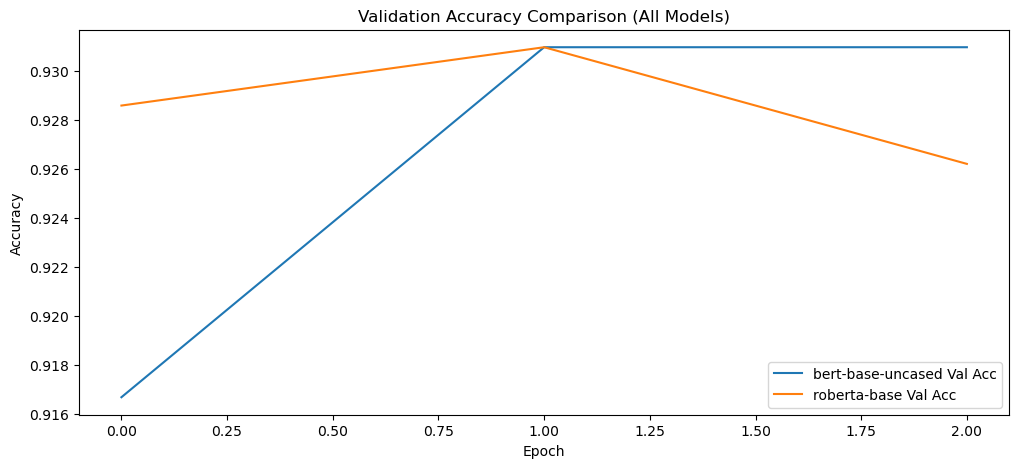


Final Results Comparison (All Models):
Model                               Accuracy   F1-Score  
-------------------------------------------------------
bert-base-uncased                   0.9310     0.9277
roberta-base                        0.9262     0.9231


In [122]:

# Plot Comparison
if 'results' in locals() and results:
    plt.figure(figsize=(12, 5))

    for model_name, data in results.items():
        if 'history' in data and 'val_acc' in data['history']:
            plt.plot(data['history']['val_acc'], label=f"{model_name} Val Acc")

    plt.title('Validation Accuracy Comparison (All Models)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('model_comparison.png')
    plt.show()
    
    # Print Final Table
    print("\nFinal Results Comparison (All Models):")
    print(f"{'Model':<35} {'Accuracy':<10} {'F1-Score':<10}")
    print("-" * 55)
    for model_name, data in results.items():
        if 'metrics' in data:
            acc = data['metrics'].get('accuracy', 0)
            f1 = data['metrics'].get('f1', 0)
            print(f"{model_name:<35} {acc:.4f}     {f1:.4f}")
else:
    print("No results to plot.")


## 6. Siamese LSTM Model (From Scratch)
This model does not use any pre-trained weights. It learns embeddings from scratch and uses an LSTM to encode the sentences.

In [123]:
# Custom Tokenizer and Vocabulary
class SimpleTokenizer:
    def __init__(self, max_vocab_size=10000):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.vocab_size = 2
        self.max_vocab_size = max_vocab_size
        
    def fit(self, texts):
        word_counts = collections.Counter()
        for text in texts:
            if isinstance(text, str):
                words = text.lower().split()
                word_counts.update(words)
        
        # Add most common words to vocab
        for word, _ in word_counts.most_common(self.max_vocab_size - 2):
            self.word2idx[word] = self.vocab_size
            self.idx2word[self.vocab_size] = word
            self.vocab_size += 1
            
    def encode(self, text, max_len=128):
        if not isinstance(text, str):
            return [0] * max_len
        words = text.lower().split()
        ids = [self.word2idx.get(w, 1) for w in words] 
        # Pad or Truncate
        if len(ids) > max_len:
            ids = ids[:max_len]
        else:
            ids = ids + [0] * (max_len - len(ids)) 
        return ids

# Dataset for LSTM
class LSTMTripletDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        ids_anc = self.tokenizer.encode(row['anchor_text'], self.max_len)
        ids_a = self.tokenizer.encode(row['text_a'], self.max_len)
        ids_b = self.tokenizer.encode(row['text_b'], self.max_len)
        
        # Create masks (1 for real tokens, 0 for pad)
        mask_anc = [1 if i != 0 else 0 for i in ids_anc]
        mask_a = [1 if i != 0 else 0 for i in ids_a]
        mask_b = [1 if i != 0 else 0 for i in ids_b]
        
        return {
            'input_ids_anc': torch.tensor(ids_anc, dtype=torch.long),
            'attention_mask_anc': torch.tensor(mask_anc, dtype=torch.long),
            'input_ids_a': torch.tensor(ids_a, dtype=torch.long),
            'attention_mask_a': torch.tensor(mask_a, dtype=torch.long),
            'input_ids_b': torch.tensor(ids_b, dtype=torch.long),
            'attention_mask_b': torch.tensor(mask_b, dtype=torch.long),
            'label': torch.tensor(row['label'], dtype=torch.long)
        }

# Siamese LSTM Model
class SiameseLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128):
        super(SiameseLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        
    def forward(self, input_ids, attention_mask):
        # Embeddings
        emb = self.embedding(input_ids)
        
        # LSTM
        output, _ = self.lstm(emb)
        
        # Mean Pooling using Mask
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(output.size()).float()
        sum_embeddings = torch.sum(output * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        embeddings = sum_embeddings / sum_mask
        
        return embeddings

class SiameseLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128):
        super(SiameseLSTMClassifier, self).__init__()
        self.encoder = SiameseLSTM(vocab_size, embedding_dim, hidden_dim)
        # LSTM is bidirectional, so output dim is hidden_dim * 2
        # Input to FC is (u, v, |u-v|) -> 3 * hidden_dim * 2
        self.cos = nn.CosineSimilarity(dim=1)
        self.fc = nn.Linear(hidden_dim * 2 * 4 + 1, 2)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, input_ids_anc, attention_mask_anc, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b):
        emb_anc = self.encoder(input_ids_anc, attention_mask_anc)
        emb_a = self.encoder(input_ids_a, attention_mask_a)
        emb_b = self.encoder(input_ids_b, attention_mask_b)
        cos_sim = self.cos(emb_a, emb_b).unsqueeze(1)
        
        combined = torch.cat((emb_anc, emb_a, emb_b, torch.abs(emb_a - emb_b), cos_sim), dim=1)
        output = self.fc(self.dropout(combined))
        return output

    def task_b(self, input_ids, attention_mask):
        return self.encoder(input_ids, attention_mask)


## 7. Siamese Transformer Model (From Scratch)
This model defines a Transformer block manually and trains it from scratch without using any pre-trained weights.

In [124]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-Attention
        # src_key_padding_mask should be True for pad tokens. Our mask is 1 for real, 0 for pad.
        # So we need to invert our mask: 0 -> True (Ignore), 1 -> False (Keep)
        # But PyTorch MultiheadAttention key_padding_mask expects: True for value that should be ignored.
        
        key_padding_mask = (src_key_padding_mask == 0) if src_key_padding_mask is not None else None

        src2, _ = self.self_attn(src, src, src, key_padding_mask=key_padding_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        # Feed Forward
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class SiameseTransformerScratch(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=10, dim_feedforward=512, max_len=128):
        super(SiameseTransformerScratch, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        
        # Stack Transformer Blocks
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, nhead, dim_feedforward) for _ in range(num_layers)
        ])
        
        self.d_model = d_model

    def forward(self, input_ids, attention_mask):
        # Embed
        x = self.embedding(input_ids) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        
        # Pass through layers
        for layer in self.layers:
            x = layer(x, src_key_padding_mask=attention_mask)
            
        # Mean Pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(x.size()).float()
        sum_embeddings = torch.sum(x * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        embeddings = sum_embeddings / sum_mask
        
        return embeddings

class SiameseTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, dim_feedforward=512, max_len=128):
        super(SiameseTransformerClassifier, self).__init__()
        self.encoder = SiameseTransformerScratch(vocab_size, d_model, nhead, num_layers, dim_feedforward, max_len)
        # Input to FC is (u, v, |u-v|) -> 3 * d_model
        self.cos = nn.CosineSimilarity(dim=1)
        self.fc = nn.Linear(d_model * 4 + 1, 2)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, input_ids_anc, attention_mask_anc, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b):
        emb_anc = self.encoder(input_ids_anc, attention_mask_anc)
        emb_a = self.encoder(input_ids_a, attention_mask_a)
        emb_b = self.encoder(input_ids_b, attention_mask_b)
        cos_sim = self.cos(emb_a, emb_b).unsqueeze(1)
        
        combined = torch.cat((emb_anc, emb_a, emb_b, torch.abs(emb_a - emb_b), cos_sim), dim=1)
        output = self.fc(self.dropout(combined))
        return output

    def task_b(self, input_ids, attention_mask):
        return self.encoder(input_ids, attention_mask)


In [125]:
def train_epoch_3text(model, data_loader, loss_fn, optimizer, device, scheduler=None):
    model.train()
    losses = []
    correct_predictions = 0
    
    for batch in tqdm(data_loader, desc="Training", leave=False):
        input_ids_anc = batch['input_ids_anc'].to(device)
        attention_mask_anc = batch['attention_mask_anc'].to(device)
        input_ids_a = batch['input_ids_a'].to(device)
        attention_mask_a = batch['attention_mask_a'].to(device)
        input_ids_b = batch['input_ids_b'].to(device)
        attention_mask_b = batch['attention_mask_b'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()

        outputs = model(input_ids_anc, attention_mask_anc, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b)
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
            
    return correct_predictions.float() / len(data_loader.dataset), np.mean(losses)

def eval_model_3text(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids_anc = batch['input_ids_anc'].to(device)
            attention_mask_anc = batch['attention_mask_anc'].to(device)
            input_ids_a = batch['input_ids_a'].to(device)
            attention_mask_a = batch['attention_mask_a'].to(device)
            input_ids_b = batch['input_ids_b'].to(device)
            attention_mask_b = batch['attention_mask_b'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids_anc, attention_mask_anc, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b)
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    accuracy = correct_predictions.float() / len(data_loader.dataset)
    
    metrics = {
        'accuracy': accuracy.item(),
        'loss': np.mean(losses),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }
    
    return metrics

In [126]:

# Initialize Tokenizer
my_tokenizer = SimpleTokenizer(max_vocab_size=10000)
all_text = pd.concat([df['anchor_text'], df['text_a'], df['text_b']]).tolist()
my_tokenizer.fit(all_text)
print(f"Vocab Size: {my_tokenizer.vocab_size}")

def run_experiment_lstm(df, tokenizer, vocab_size, epochs=10, batch_size=32):
    print(f"\n{'='*20}\nRunning Siamese LSTM (Scratch)\n{'='*20}")
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    train_dataset = LSTMTripletDataset(train_df, tokenizer)
    val_dataset = LSTMTripletDataset(val_df, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = SiameseLSTMClassifier(vocab_size)
    model = model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    history = {
        'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'val_loss': []
    }
    
    best_f1 = 0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        
        train_acc, train_loss = train_epoch_3text(
            model, train_loader, loss_fn, optimizer, device
        )
        
        val_metrics = eval_model_3text(
            model, val_loader, loss_fn, device
        )
        
        print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
        print(f'Val   loss {val_metrics["loss"]:.4f} accuracy {val_metrics["accuracy"]:.4f}')
        print(f'Val   F1 {val_metrics["f1"]:.4f}')
        
        history['train_acc'].append(train_acc.item())
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_loss'].append(val_metrics['loss'])
        
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            
    return history, val_metrics, model

# Run LSTM
if 'results' not in locals(): results = {}
history_lstm, metrics_lstm , model_lstm = run_experiment_lstm(df, my_tokenizer, my_tokenizer.vocab_size, epochs=10, batch_size=32)
results['Siamese-LSTM'] = {'history': history_lstm, 'metrics': metrics_lstm}
if torch.cuda.is_available():
    torch.cuda.empty_cache()
if torch.mps.is_available():
    torch.mps.empty_cache()


Vocab Size: 10000

Running Siamese LSTM (Scratch)
Epoch 1/10


Train loss 0.5741 accuracy 0.7144
Val   loss 0.5068 accuracy 0.7500
Val   F1 0.7091
Epoch 2/10


Train loss 0.4212 accuracy 0.7961
Val   loss 0.3689 accuracy 0.8405
Val   F1 0.8393
Epoch 3/10


Train loss 0.2770 accuracy 0.8754
Val   loss 0.3813 accuracy 0.8381
Val   F1 0.8229
Epoch 4/10


Train loss 0.2790 accuracy 0.8909
Val   loss 0.2742 accuracy 0.8857
Val   F1 0.8829
Epoch 5/10


Train loss 0.1791 accuracy 0.9201
Val   loss 0.2629 accuracy 0.8762
Val   F1 0.8725
Epoch 6/10


Train loss 0.1489 accuracy 0.9434
Val   loss 0.3409 accuracy 0.8738
Val   F1 0.8672
Epoch 7/10


Train loss 0.1059 accuracy 0.9600
Val   loss 0.2351 accuracy 0.9048
Val   F1 0.9034
Epoch 8/10


Train loss 0.0615 accuracy 0.9773
Val   loss 0.2269 accuracy 0.9000
Val   F1 0.8960
Epoch 9/10


Train loss 0.0474 accuracy 0.9869
Val   loss 0.2469 accuracy 0.8976
Val   F1 0.8959
Epoch 10/10


Train loss 0.0270 accuracy 0.9928
Val   loss 0.2539 accuracy 0.9143
Val   F1 0.9130


## Task B LSTM

In [127]:
embeddings = []

data_loader = TaskBDataLoader(df_task_b, my_tokenizer)

emb = task_b_embeddings(data_loader, model, device)

final_embeddings['Siamese-LSTM'] = emb

print(final_embeddings['Siamese-LSTM'].shape)

100%|██████████| 479/479 [00:07<00:00, 68.09it/s]

(479, 768)


In [128]:

# Initialize Tokenizer
my_tokenizer = SimpleTokenizer(max_vocab_size=10000)
all_text = pd.concat([df['anchor_text'], df['text_a'], df['text_b']]).tolist()
my_tokenizer.fit(all_text)
print(f"Vocab Size: {my_tokenizer.vocab_size}")

def run_experiment_transformer(df, tokenizer, vocab_size, epochs=10, batch_size=32):
    print(f"\n{'='*20}\nRunning Siamese Transformer (Scratch)\n{'='*20}")
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    train_dataset = LSTMTripletDataset(train_df, tokenizer)
    val_dataset = LSTMTripletDataset(val_df, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = SiameseTransformerClassifier(vocab_size)
    model = model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    history = {
        'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'val_loss': []
    }
    
    best_f1 = 0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        
        train_acc, train_loss = train_epoch_3text(
            model, train_loader, loss_fn, optimizer, device
        )
        
        val_metrics = eval_model_3text(
            model, val_loader, loss_fn, device
        )
        
        print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
        print(f'Val   loss {val_metrics["loss"]:.4f} accuracy {val_metrics["accuracy"]:.4f}')
        print(f'Val   F1 {val_metrics["f1"]:.4f}')
        
        history['train_acc'].append(train_acc.item())
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_loss'].append(val_metrics['loss'])
        
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            
    return history, val_metrics, model

# Run LSTM
if 'results' not in locals(): results = {}
history_transformer, metrics_transformer, model_transformer = run_experiment_transformer(df, my_tokenizer, my_tokenizer.vocab_size, epochs=10, batch_size=32)
results['Siamese-Transformer'] = {'history': history_transformer, 'metrics': metrics_transformer}
if torch.cuda.is_available():
    torch.cuda.empty_cache()
if torch.mps.is_available():
    torch.mps.empty_cache()


Vocab Size: 10000

Running Siamese Transformer (Scratch)
Epoch 1/10


Train loss 0.4930 accuracy 0.7460
Val   loss 0.2601 accuracy 0.8810
Val   F1 0.8750
Epoch 2/10


Train loss 0.2171 accuracy 0.9207
Val   loss 0.2833 accuracy 0.8714
Val   F1 0.8556
Epoch 3/10


Train loss 0.1293 accuracy 0.9469
Val   loss 0.2524 accuracy 0.8786
Val   F1 0.8741
Epoch 4/10


Train loss 0.0726 accuracy 0.9732
Val   loss 0.3264 accuracy 0.9143
Val   F1 0.9100
Epoch 5/10


Train loss 0.0461 accuracy 0.9851
Val   loss 0.3931 accuracy 0.8762
Val   F1 0.8693
Epoch 6/10


Train loss 0.0311 accuracy 0.9917
Val   loss 0.4070 accuracy 0.8881
Val   F1 0.8834
Epoch 7/10


Train loss 0.0233 accuracy 0.9946
Val   loss 0.4944 accuracy 0.8857
Val   F1 0.8782
Epoch 8/10


Train loss 0.0283 accuracy 0.9899
Val   loss 0.4198 accuracy 0.9071
Val   F1 0.9018
Epoch 9/10


Train loss 0.0294 accuracy 0.9887
Val   loss 0.3434 accuracy 0.8762
Val   F1 0.8706
Epoch 10/10


Train loss 0.0273 accuracy 0.9905
Val   loss 0.5009 accuracy 0.8738
Val   F1 0.8665


## Task B Transformer

In [129]:
embeddings = []

data_loader = TaskBDataLoader(df_task_b, my_tokenizer)

emb = task_b_embeddings(data_loader, model, device)

final_embeddings['Siamese-Tramsformer'] = emb
print(final_embeddings['Siamese-Tramsformer'].shape)

100%|██████████| 479/479 [00:06<00:00, 71.25it/s]

(479, 768)


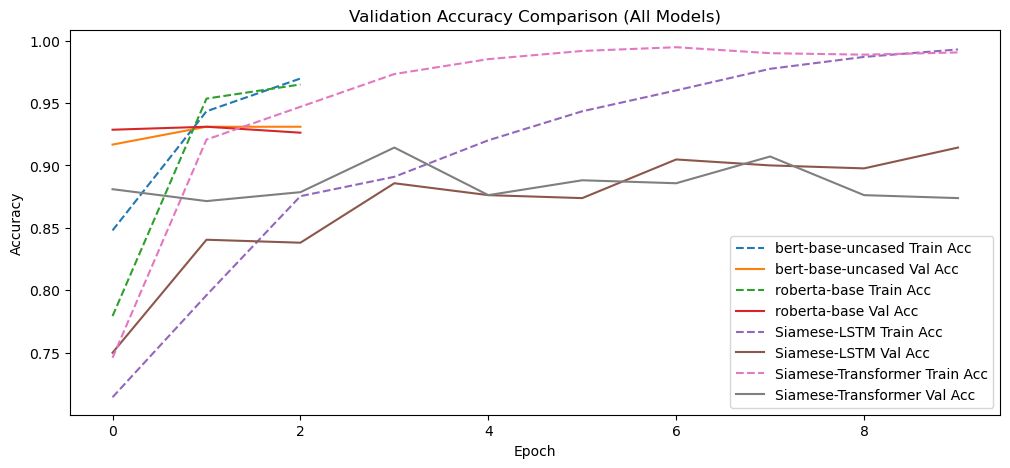


Final Results Comparison (All Models):
Model                               Accuracy   F1-Score  
-------------------------------------------------------
bert-base-uncased                   0.9310     0.9277
roberta-base                        0.9262     0.9231
Siamese-LSTM                        0.9143     0.9130
Siamese-Transformer                 0.8738     0.8665


In [130]:

# Plot Comparison
if 'results' in locals() and results:
    plt.figure(figsize=(12, 5))

    for model_name, data in results.items():
        if 'history' in data and 'val_acc' in data['history']:
            plt.plot(data['history']['train_acc'], label=f"{model_name} Train Acc", linestyle='--')
            plt.plot(data['history']['val_acc'], label=f"{model_name} Val Acc")

    plt.title('Validation Accuracy Comparison (All Models)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('model_comparison.png')
    plt.show()
    
    # Print Final Table
    print("\nFinal Results Comparison (All Models):")
    print(f"{'Model':<35} {'Accuracy':<10} {'F1-Score':<10}")
    print("-" * 55)
    for model_name, data in results.items():
        if 'metrics' in data:
            acc = data['metrics'].get('accuracy', 0)
            f1 = data['metrics'].get('f1', 0)
            print(f"{model_name:<35} {acc:.4f}     {f1:.4f}")
else:
    print("No results to plot.")
